In [54]:
from torch.optim import Adam

Adam?

Init signature:
Adam(
    params,
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0,
    amsgrad=False,
)
Docstring:     
Implements Adam algorithm.

It has been proposed in `Adam: A Method for Stochastic Optimization`_.
The implementation of the L2 penalty follows changes proposed in
`Decoupled Weight Decay Regularization`_.

Args:
    params (iterable): iterable of parameters to optimize or dicts defining
        parameter groups
    lr (float, optional): learning rate (default: 1e-3)
    betas (Tuple[float, float], optional): coefficients used for computing
        running averages of gradient and its square (default: (0.9, 0.999))
    eps (float, optional): term added to the denominator to improve
        numerical stability (default: 1e-8)
    weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
    amsgrad (boolean, optional): whether to use the AMSGrad variant of this
        algorithm from the paper `On the Convergence of Adam and Beyond`

In [52]:
from lpips import LPIPS
import lpips
print(lpips)
!cat /home/sysadmin/tangdong/workspace/anaconda3/envs/cn_image_generation/lib/python3.6/site-packages/lpips/lpips.py

<module 'lpips' from '/home/sysadmin/tangdong/workspace/anaconda3/envs/cn_image_generation/lib/python3.6/site-packages/lpips/__init__.py'>

from __future__ import absolute_import

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
import numpy as np
from . import pretrained_networks as pn
import torch.nn

import lpips

def spatial_average(in_tens, keepdim=True):
    return in_tens.mean([2,3],keepdim=keepdim)

def upsample(in_tens, out_HW=(64,64)): # assumes scale factor is same for H and W
    in_H, in_W = in_tens.shape[2], in_tens.shape[3]
    return nn.Upsample(size=out_HW, mode='bilinear', align_corners=False)(in_tens)

# Learned perceptual metric
class LPIPS(nn.Module):
    def __init__(self, pretrained=True, net='alex', version='0.1', lpips=True, spatial=False, 
        pnet_rand=False, pnet_tune=False, use_dropout=True, model_path=None, eval_mode=True, verbose=True):
        """ Initializes a perceptual loss torch.nn.Module

      

In [43]:
import torch
_ = torch.manual_seed(123)
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
lpips = LearnedPerceptualImagePatchSimilarity(net_type='vgg')
# LPIPS needs the images to be in the [-1, 1] range.
img1 = (torch.ones(1, 3, 100, 100) * 2) - 1
img2 = (torch.ones(2, 3, 100, 100) * 2) - 1
print(lpips(img1, img2))

tensor(6.1059e-15, grad_fn=<SqueezeBackward0>)


In [35]:
import pytorch_lightning
pytorch_lightning.__version__

'1.5.10'

In [5]:
import torch.nn as nn
import torch
num_tokens = 20
emb_dim = 5
a = nn.Embedding(num_tokens, emb_dim)


In [32]:
c = torch.tensor(torch.ones([8,5]),dtype=int)
print(c)
test = a(c)
test2 = a(torch.tensor(1))

tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]])


/home/sysadmin/tangdong/workspace/anaconda3/envs/cn_image_generation/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [31]:
test.shape

torch.Size([8, 5, 5])

In [14]:
print(test.shape,test2.shape)

torch.Size([5]) torch.Size([5])


In [1]:
from base_model import UNet_Tranformer
from base_model import marginal_prob_std_fn,diffusion_coeff_fn
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
import os

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [2]:
from loss import loss_fn_cond, loss_fn

In [3]:
#@title A handy training function
def train_diffusion_model(dataset,
                          score_model,
                          n_epochs =   100,
                          batch_size =  1024,
                          lr=10e-4,
                          model_name="transformer"):

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

    optimizer = Adam(score_model.parameters(), lr=lr)
    scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.1, 0.99 ** epoch))
    tqdm_epoch = trange(n_epochs)
    for epoch in tqdm_epoch:
        avg_loss = 0.
        num_items = 0
        for x, y in data_loader:
            x = x.to(device)    
            loss = loss_fn(score_model, x, marginal_prob_std_fn)
            optimizer.zero_grad()
            loss.backward()    
            optimizer.step()
            avg_loss += loss.item() * x.shape[0]
            num_items += x.shape[0]
        scheduler.step()
        lr_current = scheduler.get_last_lr()[0]
        print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
        # Print the averaged training loss so far.
        tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
        # Update the checkpoint after each epoch of training.
        torch.save(score_model.state_dict(), f'ckpt_{model_name}.pth')

In [4]:
batch_size =  1024
dataset = MNIST('/home/sysadmin/tangdong/workspace/pytorch_lightning', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

In [5]:
device = torch.device('cuda')
# Feel free to play with hyperparameters for training!
score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn,text_dim=None,num_heads=1))
score_model = score_model.to(device)
train_diffusion_model(dataset, score_model,
                      n_epochs =   2,
                      batch_size =  1024,
                      lr=10e-4,
                      model_name="uncondition_transformer_head1")

  0%|          | 0/2 [00:00<?, ?it/s]

/home/sysadmin/tangdong/workspace/diffusio_from_scratch/base_model.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


0 Average Loss: 878.789562 lr 9.9e-04
1 Average Loss: 266.087419 lr 9.8e-04


In [6]:
from utils import visualize_digit_embedding, save_samples_uncond,save_samples_uncond
from sample import Euler_Maruyama_sampler

In [7]:
import math
# def visualize_digit_embedding(digit_embed):
#     cossim_mat = []
#     for i in range(10):
#         cossim = torch.cosine_similarity(digit_embed, digit_embed[i:i+1,:]).cpu()
#         cossim_mat.append(cossim)
#     cossim_mat = torch.stack(cossim_mat)
#     cossim_mat_nodiag = cossim_mat + torch.diag_embed(math.nan * torch.ones(10))
#     plt.imshow(cossim_mat_nodiag)
#     plt.show()
#     return cossim_mat

In [8]:
# cossim_mat = visualize_digit_embedding(score_model.module.cond_embed.weight.data)

  0%|          | 0/250 [00:00<?, ?it/s]/home/sysadmin/tangdong/workspace/diffusio_from_scratch/base_model.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
100%|██████████| 250/250 [00:01<00:00, 190.96it/s]


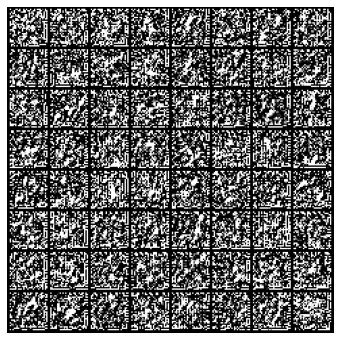

In [9]:
save_samples_uncond(score_model,"unet_transformer_head1") # model with res connection